In [2]:
import numpy as np
import pandas as pd
from scipy.sparse import diags
from scipy.sparse.linalg import svds
from tqdm import tqdm

from dataprep import transform_indices, reindex_data, generate_interactions_matrix
from evaluation import downvote_seen_items, topn_recommendations


from scipy.sparse import csr_matrix
from scipy.sparse import hstack as sp_hstack
from scipy.sparse import diags as spdiags
from scipy.sparse import eye as speye

from polara.preprocessing.dataframes import matrix_from_observations

from lightfm import LightFM
from lightfm.data import Dataset
from lightfm import cross_validation

/Users/nikitasuhorukov/opt/anaconda3/lib/python3.8/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [3]:
df = pd.read_csv('archive/animelists_cleaned.csv')

In [4]:
df_users = pd.read_csv('archive/users_cleaned.csv')

In [5]:
df_items = pd.read_csv('archive/anime_cleaned.csv')

In [6]:

df.head()

,username,anime_id,my_watched_episodes,my_start_date,my_finish_date,my_score,my_status,my_rewatching,my_rewatching_ep,my_last_updated,my_tags
0,karthiga,21,586,0000-00-00,0000-00-00,9,1,NaN,0,2013-03-03 10:52:53,NaN
1,karthiga,59,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-03-10 13:54:51,NaN
2,karthiga,74,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-04-27 16:43:35,NaN
3,karthiga,120,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-03-03 10:53:57,NaN
4,karthiga,178,26,0000-00-00,0000-00-00,7,2,0.0,0,2013-03-27 15:59:13,NaN


In [7]:
df_users.head()

,username,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location,birth_date,access_rank,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes
0,karthiga,2255153,3,49,1,0,0,55.091667,Female,"Chennai, India",1990-04-29 00:00:00,NaN,2013-03-03 00:00:00,2014-02-04 01:32:00,7.43,0.0,3391
1,Damonashu,37326,45,195,27,25,59,82.574306,Male,"Detroit,Michigan",1991-08-01 00:00:00,NaN,2008-02-13 00:00:00,2017-07-10 06:52:54,6.15,6.0,4903
2,bskai,228342,25,414,2,5,11,159.483333,Male,"Nayarit, Mexico",1990-12-14 00:00:00,NaN,2009-08-31 00:00:00,2014-05-12 16:35:00,8.27,1.0,9701
3,terune_uzumaki,327311,5,5,0,0,0,11.394444,Female,"Malaysia, Kuantan",1998-08-24 00:00:00,NaN,2010-05-10 00:00:00,2012-10-18 19:06:00,9.70,6.0,697
4,Bas_G,5015094,35,114,6,20,175,30.458333,Male,"Nijmegen, Nederland",1999-10-24 00:00:00,NaN,2015-11-26 00:00:00,2018-05-10 20:53:37,7.86,0.0,1847


In [8]:
username2userid = df_users.set_index('username').to_dict()['user_id']

In [9]:
df['userid'] = df['username'].apply(lambda x: username2userid[x])

In [10]:
df_items.head()

,anime_id,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,...,broadcast,related,producer,licensor,studio,genre,opening_theme,ending_theme,duration_min,aired_from_year
0,11013,Inu x Boku SS,Inu X Boku Secret Service,妖狐×僕SS,Youko x Boku SS,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,12,Finished Airing,...,Fridays at Unknown,"{'Adaptation': [{'mal_id': 17207, 'type': 'man...","Aniplex, Square Enix, Mainichi Broadcasting Sy...",Sentai Filmworks,David Production,"Comedy, Supernatural, Romance, Shounen","['""Nirvana"" by MUCC']","['#1: ""Nirvana"" by MUCC (eps 1, 11-12)', '#2: ...",24.0,2012.0
1,2104,Seto no Hanayome,My Bride is a Mermaid,瀬戸の花嫁,The Inland Sea Bride,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,26,Finished Airing,...,Unknown,"{'Adaptation': [{'mal_id': 759, 'type': 'manga...","TV Tokyo, AIC, Square Enix, Sotsu",Funimation,Gonzo,"Comedy, Parody, Romance, School, Shounen","['""Romantic summer"" by SUN&LUNAR']","['#1: ""Ashita e no Hikari (明日への光)"" by Asuka Hi...",24.0,2007.0
2,5262,Shugo Chara!! Doki,Shugo Chara!! Doki,しゅごキャラ！！どきっ,"Shugo Chara Ninenme, Shugo Chara! Second Year",https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,51,Finished Airing,...,Unknown,"{'Adaptation': [{'mal_id': 101, 'type': 'manga...","TV Tokyo, Sotsu",NaN,Satelight,"Comedy, Magic, School, Shoujo","['#1: ""Minna no Tamago (みんなのたまご)"" by Shugo Cha...","['#1: ""Rottara Rottara (ロッタラ ロッタラ)"" by Buono! ...",24.0,2008.0
3,721,Princess Tutu,Princess Tutu,プリンセスチュチュ,NaN,https://myanimelist.cdn-dena.com/images/anime/...,TV,Original,38,Finished Airing,...,Fridays at Unknown,"{'Adaptation': [{'mal_id': 1581, 'type': 'mang...","Memory-Tech, GANSIS, Marvelous AQL",ADV Films,Hal Film Maker,"Comedy, Drama, Magic, Romance, Fantasy","['""Morning Grace"" by Ritsuko Okazaki']","['""Watashi No Ai Wa Chiisaikeredo"" by Ritsuko ...",16.0,2002.0
4,12365,Bakuman. 3rd Season,Bakuman.,バクマン。,Bakuman Season 3,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,25,Finished Airing,...,Unknown,"{'Adaptation': [{'mal_id': 9711, 'type': 'mang...","NHK, Shueisha",NaN,J.C.Staff,"Comedy, Drama, Romance, Shounen","['#1: ""Moshimo no Hanashi (もしもの話)"" by nano.RIP...","['#1: ""Pride on Everyday"" by Sphere (eps 1-13)...",24.0,2012.0


In [11]:
df_items.title_english.fillna('00000')

0       Inu X Boku Secret Service
1           My Bride is a Mermaid
2              Shugo Chara!! Doki
3                   Princess Tutu
4                        Bakuman.
                  ...            
6663                        00000
6664           I&#039;m Joybo OVA
6665                        00000
6666          Mr. Men Little Miss
6667                        00000
Name: title_english, Length: 6668, dtype: object

In [12]:
titles = df_items.title.values
english_titles = df_items.title_english.fillna('00000').values
for i in range(len(english_titles)):
    if english_titles[i] == '00000':
        english_titles[i] = titles[i]
english_titles[-1]

'Mushi Mushi Mura no Nakama-tachi: Minna Ii Toko Arun Da yo'

In [13]:
df_items['new_title'] = english_titles

In [14]:
df_items

,anime_id,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,...,related,producer,licensor,studio,genre,opening_theme,ending_theme,duration_min,aired_from_year,new_title
0,11013,Inu x Boku SS,Inu X Boku Secret Service,妖狐×僕SS,Youko x Boku SS,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,12,Finished Airing,...,"{'Adaptation': [{'mal_id': 17207, 'type': 'man...","Aniplex, Square Enix, Mainichi Broadcasting Sy...",Sentai Filmworks,David Production,"Comedy, Supernatural, Romance, Shounen","['""Nirvana"" by MUCC']","['#1: ""Nirvana"" by MUCC (eps 1, 11-12)', '#2: ...",24.0,2012.0,Inu X Boku Secret Service
1,2104,Seto no Hanayome,My Bride is a Mermaid,瀬戸の花嫁,The Inland Sea Bride,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,26,Finished Airing,...,"{'Adaptation': [{'mal_id': 759, 'type': 'manga...","TV Tokyo, AIC, Square Enix, Sotsu",Funimation,Gonzo,"Comedy, Parody, Romance, School, Shounen","['""Romantic summer"" by SUN&LUNAR']","['#1: ""Ashita e no Hikari (明日への光)"" by Asuka Hi...",24.0,2007.0,My Bride is a Mermaid
2,5262,Shugo Chara!! Doki,Shugo Chara!! Doki,しゅごキャラ！！どきっ,"Shugo Chara Ninenme, Shugo Chara! Second Year",https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,51,Finished Airing,...,"{'Adaptation': [{'mal_id': 101, 'type': 'manga...","TV Tokyo, Sotsu",NaN,Satelight,"Comedy, Magic, School, Shoujo","['#1: ""Minna no Tamago (みんなのたまご)"" by Shugo Cha...","['#1: ""Rottara Rottara (ロッタラ ロッタラ)"" by Buono! ...",24.0,2008.0,Shugo Chara!! Doki
3,721,Princess Tutu,Princess Tutu,プリンセスチュチュ,NaN,https://myanimelist.cdn-dena.com/images/anime/...,TV,Original,38,Finished Airing,...,"{'Adaptation': [{'mal_id': 1581, 'type': 'mang...","Memory-Tech, GANSIS, Marvelous AQL",ADV Films,Hal Film Maker,"Comedy, Drama, Magic, Romance, Fantasy","['""Morning Grace"" by Ritsuko Okazaki']","['""Watashi No Ai Wa Chiisaikeredo"" by Ritsuko ...",16.0,2002.0,Princess Tutu
4,12365,Bakuman. 3rd Season,Bakuman.,バクマン。,Bakuman Season 3,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,25,Finished Airing,...,"{'Adaptation': [{'mal_id': 9711, 'type': 'mang...","NHK, Shueisha",NaN,J.C.Staff,"Comedy, Drama, Romance, Shounen","['#1: ""Moshimo no Hanashi (もしもの話)"" by nano.RIP...","['#1: ""Pride on Everyday"" by Sphere (eps 1-13)...",24.0,2012.0,Bakuman.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6663,37405,Dokidoki Little Ooyasan,NaN,dokidokiりとる大家さん,NaN,https://myanimelist.cdn-dena.com/images/anime/...,OVA,Other,0,Currently Airing,...,[],NaN,NaN,Collaboration Works,Hentai,[],[],30.0,2018.0,Dokidoki Little Ooyasan
6664,37886,Wo Shi Jiang Xiaobai (2018),I&#039;m Joybo OVA,我是江小白 小剧场,Wo Shi Jiang Xiao Bai: Xiao Ju Chang,https://myanimelist.cdn-dena.com/images/anime/...,ONA,Original,1,Finished Airing,...,"{'Prequel': [{'mal_id': 36775, 'type': 'anime'...",NaN,NaN,2:10 Animation,"Slice of Life, Drama, Romance",[],[],0.0,2018.0,I&#039;m Joybo OVA
6665,37255,Genki Genki Non-tan: Obake Mura Meiro,NaN,げんきげんきノンタン おばけむらめいろ,NaN,https://myanimelist.cdn-dena.com/images/anime/...,OVA,Original,1,Finished Airing,...,"{'Prequel': [{'mal_id': 25619, 'type': 'anime'...",NaN,NaN,Polygon Pictures,"Music, Kids",[],[],35.0,2015.0,Genki Genki Non-tan: Obake Mura Meiro
6666,35229,Mr. Men Little Miss,Mr. Men Little Miss,Mr. Men Little Miss / ミスターメン リトルミス,NaN,https://myanimelist.cdn-dena.com/images/anime/...,ONA,Picture book,0,Currently Airing,...,[],NaN,NaN,Sanrio,Kids,[],[],2.0,2013.0,Mr. Men Little Miss


In [15]:
anime_id2anime_name = df_items.set_index('anime_id').to_dict()['new_title']
anime_name2anime_id = df_items.set_index('new_title').to_dict()['anime_id']

In [16]:
import json

with open('anime_id2anime_name.json', 'w') as fp:
    json.dump(anime_id2anime_name, fp)
    
with open('anime_name2anime_id.json', 'w') as fp:
    json.dump(anime_name2anime_id, fp)

In [17]:
df_items.columns

Index(['anime_id', 'title', 'title_english', 'title_japanese',
       'title_synonyms', 'image_url', 'type', 'source', 'episodes', 'status',
       'airing', 'aired_string', 'aired', 'duration', 'rating', 'score',
       'scored_by', 'rank', 'popularity', 'members', 'favorites', 'background',
       'premiered', 'broadcast', 'related', 'producer', 'licensor', 'studio',
       'genre', 'opening_theme', 'ending_theme', 'duration_min',
       'aired_from_year', 'new_title'],
      dtype='object')

In [18]:
data_items = df_items[['anime_id',  'new_title', 
         'type', 'source', 
       'score',
       'scored_by', 'members', 'favorites',
       'genre']]

In [19]:
data_items

,anime_id,new_title,type,source,score,scored_by,members,favorites,genre
0,11013,Inu X Boku Secret Service,TV,Manga,7.63,139250,283882,2809,"Comedy, Supernatural, Romance, Shounen"
1,2104,My Bride is a Mermaid,TV,Manga,7.89,91206,204003,2579,"Comedy, Parody, Romance, School, Shounen"
2,5262,Shugo Chara!! Doki,TV,Manga,7.55,37129,70127,802,"Comedy, Magic, School, Shoujo"
3,721,Princess Tutu,TV,Original,8.21,36501,93312,3344,"Comedy, Drama, Magic, Romance, Fantasy"
4,12365,Bakuman.,TV,Manga,8.67,107767,182765,2082,"Comedy, Drama, Romance, Shounen"
...,...,...,...,...,...,...,...,...,...
6663,37405,Dokidoki Little Ooyasan,OVA,Other,9.52,33,357,21,Hentai
6664,37886,I&#039;m Joybo OVA,ONA,Original,0.00,0,384,1,"Slice of Life, Drama, Romance"
6665,37255,Genki Genki Non-tan: Obake Mura Meiro,OVA,Original,4.20,5,37,0,"Music, Kids"
6666,35229,Mr. Men Little Miss,ONA,Picture book,4.57,7,49,1,Kids


In [20]:
df_users

,username,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location,birth_date,access_rank,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes
0,karthiga,2255153,3,49,1,0,0,55.091667,Female,"Chennai, India",1990-04-29 00:00:00,NaN,2013-03-03 00:00:00,2014-02-04 01:32:00,7.43,0.0,3391
1,Damonashu,37326,45,195,27,25,59,82.574306,Male,"Detroit,Michigan",1991-08-01 00:00:00,NaN,2008-02-13 00:00:00,2017-07-10 06:52:54,6.15,6.0,4903
2,bskai,228342,25,414,2,5,11,159.483333,Male,"Nayarit, Mexico",1990-12-14 00:00:00,NaN,2009-08-31 00:00:00,2014-05-12 16:35:00,8.27,1.0,9701
3,terune_uzumaki,327311,5,5,0,0,0,11.394444,Female,"Malaysia, Kuantan",1998-08-24 00:00:00,NaN,2010-05-10 00:00:00,2012-10-18 19:06:00,9.70,6.0,697
4,Bas_G,5015094,35,114,6,20,175,30.458333,Male,"Nijmegen, Nederland",1999-10-24 00:00:00,NaN,2015-11-26 00:00:00,2018-05-10 20:53:37,7.86,0.0,1847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108706,isoann,797785,14,213,11,20,136,64.372222,Male,Poland:,1997-01-13 00:00:00,NaN,2011-10-23 00:00:00,2018-02-25 01:20:27,8.03,2.0,3939
108707,bumcakee,1396285,13,116,5,9,22,41.365972,Female,"nhollywood, california",1998-07-18 00:00:00,NaN,2012-07-14 00:00:00,2017-02-14 00:30:00,8.86,24.0,2537
108708,Scarlet95,2478991,6,103,10,8,54,46.827083,Female,Belgium,1995-10-17 00:00:00,NaN,2013-04-24 00:00:00,2016-12-18 08:41:00,7.40,1.0,2869
108709,Torasori,3975907,22,239,0,4,176,72.361111,Male,"Latvia, Riga",1998-11-18 00:00:00,NaN,2014-07-30 00:00:00,2018-05-24 21:34:46,8.98,47.0,4469


In [21]:
df_users.columns

Index(['username', 'user_id', 'user_watching', 'user_completed', 'user_onhold',
       'user_dropped', 'user_plantowatch', 'user_days_spent_watching',
       'gender', 'location', 'birth_date', 'access_rank', 'join_date',
       'last_online', 'stats_mean_score', 'stats_rewatched', 'stats_episodes'],
      dtype='object')

In [22]:
data_users = df_users[['username', 'user_id', 'gender', 'birth_date']]

In [23]:
data_users

,username,user_id,gender,birth_date
0,karthiga,2255153,Female,1990-04-29 00:00:00
1,Damonashu,37326,Male,1991-08-01 00:00:00
2,bskai,228342,Male,1990-12-14 00:00:00
3,terune_uzumaki,327311,Female,1998-08-24 00:00:00
4,Bas_G,5015094,Male,1999-10-24 00:00:00
...,...,...,...,...
108706,isoann,797785,Male,1997-01-13 00:00:00
108707,bumcakee,1396285,Female,1998-07-18 00:00:00
108708,Scarlet95,2478991,Female,1995-10-17 00:00:00
108709,Torasori,3975907,Male,1998-11-18 00:00:00


In [24]:
df

,username,anime_id,my_watched_episodes,my_start_date,my_finish_date,my_score,my_status,my_rewatching,my_rewatching_ep,my_last_updated,my_tags,userid
0,karthiga,21,586,0000-00-00,0000-00-00,9,1,NaN,0,2013-03-03 10:52:53,NaN,2255153
1,karthiga,59,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-03-10 13:54:51,NaN,2255153
2,karthiga,74,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-04-27 16:43:35,NaN,2255153
3,karthiga,120,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-03-03 10:53:57,NaN,2255153
4,karthiga,178,26,0000-00-00,0000-00-00,7,2,0.0,0,2013-03-27 15:59:13,NaN,2255153
...,...,...,...,...,...,...,...,...,...,...,...,...
31284025,Yokonightcore,15611,48,2014-00-00,0000-00-00,9,1,NaN,0,2015-09-07 17:33:03,NaN,4862000
31284026,Yokonightcore,27815,22,0000-00-00,0000-00-00,9,1,NaN,0,2015-09-07 17:32:05,NaN,4862000
31284027,wargod,5945,39,0000-00-00,0000-00-00,8,2,0.0,0,2010-03-29 04:24:12,NaN,299167
31284028,JMc_SetoKai_LoVe,1316,52,0000-00-00,0000-00-00,9,2,NaN,0,2009-12-23 05:45:14,NaN,263803


In [25]:
data_interactions = df[['userid', 'anime_id', 'my_score', 'my_last_updated']].rename(columns={"userid": "userid", "anime_id": "movieid", 'my_last_updated':'timestamp', 'my_score':'rating'})

In [26]:
data_interactions

,userid,movieid,rating,timestamp
0,2255153,21,9,2013-03-03 10:52:53
1,2255153,59,7,2013-03-10 13:54:51
2,2255153,74,7,2013-04-27 16:43:35
3,2255153,120,7,2013-03-03 10:53:57
4,2255153,178,7,2013-03-27 15:59:13
...,...,...,...,...
31284025,4862000,15611,9,2015-09-07 17:33:03
31284026,4862000,27815,9,2015-09-07 17:32:05
31284027,299167,5945,8,2010-03-29 04:24:12
31284028,263803,1316,9,2009-12-23 05:45:14


In [27]:
data_interactions = data_interactions.loc[data_interactions.rating > 0]

In [28]:
data_interactions

,userid,movieid,rating,timestamp
0,2255153,21,9,2013-03-03 10:52:53
1,2255153,59,7,2013-03-10 13:54:51
2,2255153,74,7,2013-04-27 16:43:35
3,2255153,120,7,2013-03-03 10:53:57
4,2255153,178,7,2013-03-27 15:59:13
...,...,...,...,...
31284025,4862000,15611,9,2015-09-07 17:33:03
31284026,4862000,27815,9,2015-09-07 17:32:05
31284027,299167,5945,8,2010-03-29 04:24:12
31284028,263803,1316,9,2009-12-23 05:45:14


In [29]:
data_users

,username,user_id,gender,birth_date
0,karthiga,2255153,Female,1990-04-29 00:00:00
1,Damonashu,37326,Male,1991-08-01 00:00:00
2,bskai,228342,Male,1990-12-14 00:00:00
3,terune_uzumaki,327311,Female,1998-08-24 00:00:00
4,Bas_G,5015094,Male,1999-10-24 00:00:00
...,...,...,...,...
108706,isoann,797785,Male,1997-01-13 00:00:00
108707,bumcakee,1396285,Female,1998-07-18 00:00:00
108708,Scarlet95,2478991,Female,1995-10-17 00:00:00
108709,Torasori,3975907,Male,1998-11-18 00:00:00


In [30]:
shared_ids = np.intersect1d(data_users.user_id, data_interactions.userid)
data_users = data_users[data_users.user_id.isin(shared_ids)]
data_interactions = data_interactions[data_interactions.userid.isin(shared_ids)]

In [67]:
data_interactions

,userid,movieid,rating,timestamp
0,2255153,21,9,2013-03-03 10:52:53
1,2255153,59,7,2013-03-10 13:54:51
2,2255153,74,7,2013-04-27 16:43:35
3,2255153,120,7,2013-03-03 10:53:57
4,2255153,178,7,2013-03-27 15:59:13
...,...,...,...,...
31284025,4862000,15611,9,2015-09-07 17:33:03
31284026,4862000,27815,9,2015-09-07 17:32:05
31284027,299167,5945,8,2010-03-29 04:24:12
31284028,263803,1316,9,2009-12-23 05:45:14


In [68]:
data_interactions.userid.nunique()

106402

In [31]:
data_users['age'] = data_users.birth_date.apply(lambda x: 2023 - int(x[:4]))

/var/folders/bd/7mpj9jd97p5fnky8m8jmmgpw0000gn/T/ipykernel_2448/560977738.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_users['age'] = data_users.birth_date.apply(lambda x: 2023 - int(x[:4]))


In [32]:
from matplotlib import pyplot as plt

(array([  16.,   14.,   24.,   49.,  165.,  422.,  929., 1676., 2898.,
        4180., 5770., 7079., 8391., 9084., 9554., 9150., 9045., 8188.,
        7808., 5692., 4341., 3170., 2429., 1724., 1230.,  874.,  668.,
         463.,  385.,  248.,  138.,  134.,   99.,   79.,   64.,   57.,
          44.,   33.,   33.,   55.]),
 array([15.   , 15.975, 16.95 , 17.925, 18.9  , 19.875, 20.85 , 21.825,
        22.8  , 23.775, 24.75 , 25.725, 26.7  , 27.675, 28.65 , 29.625,
        30.6  , 31.575, 32.55 , 33.525, 34.5  , 35.475, 36.45 , 37.425,
        38.4  , 39.375, 40.35 , 41.325, 42.3  , 43.275, 44.25 , 45.225,
        46.2  , 47.175, 48.15 , 49.125, 50.1  , 51.075, 52.05 , 53.025,
        54.   ]),
 <BarContainer object of 40 artists>)

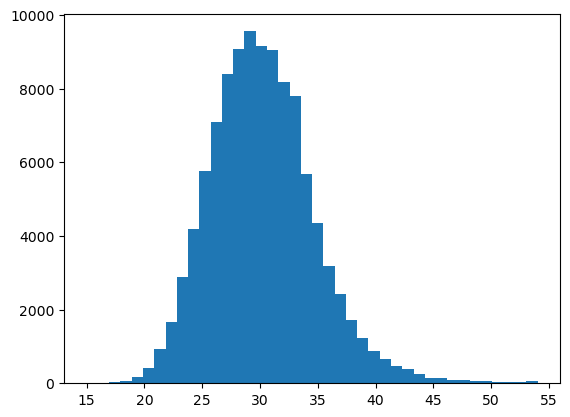

In [33]:
plt.hist(sorted(data_users.age.values), bins = 40)

In [34]:
data_users['age_group'] = pd.cut(data_users['age'], 10)

/var/folders/bd/7mpj9jd97p5fnky8m8jmmgpw0000gn/T/ipykernel_2448/3642490828.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_users['age_group'] = pd.cut(data_users['age'], 10)


In [35]:
sorted(data_users.age_group.unique())

[Interval(14.961, 18.9, closed='right'),
 Interval(18.9, 22.8, closed='right'),
 Interval(22.8, 26.7, closed='right'),
 Interval(26.7, 30.6, closed='right'),
 Interval(30.6, 34.5, closed='right'),
 Interval(34.5, 38.4, closed='right'),
 Interval(38.4, 42.3, closed='right'),
 Interval(42.3, 46.2, closed='right'),
 Interval(46.2, 50.1, closed='right'),
 Interval(50.1, 54.0, closed='right')]

In [131]:
all_item = []
for col in ['type', 'source', 'score', 'scored_by', 'members', 'favorites']:
    all_item += sorted(data_items[col].unique())
all_item += sorted(list(set(itertools.chain.from_iterable(data_items.genre))))
all_item

['typeMovie',
 'typeMusic',
 'typeONA',
 'typeOVA',
 'typeSpecial',
 'typeTV',
 'source4-koma manga',
 'sourceBook',
 'sourceCard game',
 'sourceDigital manga',
 'sourceGame',
 'sourceLight novel',
 'sourceManga',
 'sourceMusic',
 'sourceNovel',
 'sourceOriginal',
 'sourceOther',
 'sourcePicture book',
 'sourceRadio',
 'sourceVisual novel',
 'sourceWeb manga',
 'score0',
 'score1',
 'score2',
 'score3',
 'score4',
 'score5',
 'score6',
 'score7',
 'score8',
 'score9',
 'scored_by0',
 'scored_by1',
 'scored_by10',
 'scored_by2',
 'scored_by3',
 'scored_by4',
 'scored_by5',
 'scored_by6',
 'scored_by7',
 'scored_by9',
 'members0',
 'members1',
 'members10',
 'members11',
 'members13',
 'members14',
 'members2',
 'members3',
 'members4',
 'members5',
 'members6',
 'members7',
 'members8',
 'members9',
 'favorites0',
 'favorites1',
 'favorites10',
 'favorites2',
 'favorites3',
 'favorites4',
 'favorites5',
 'favorites6',
 'favorites8',
 'favorites9',
 'Action',
 'Adventure',
 'Cars',
 'Com

In [130]:
sorted(data_items['genre'].unique())

TypeError: unhashable type: 'list'

In [127]:
all_item_features

['typeMovie',
 'typeMusic',
 'typeONA',
 'typeOVA',
 'typeSpecial',
 'typeTV',
 'source4-koma manga',
 'sourceBook',
 'sourceCard game',
 'sourceDigital manga',
 'sourceGame',
 'sourceLight novel',
 'sourceManga',
 'sourceMusic',
 'sourceNovel',
 'sourceOriginal',
 'sourceOther',
 'sourcePicture book',
 'sourceRadio',
 'sourceVisual novel',
 'sourceWeb manga',
 'score0',
 'score1',
 'score2',
 'score3',
 'score4',
 'score5',
 'score6',
 'score7',
 'score8',
 'score9',
 'scored_by0',
 'scored_by1',
 'scored_by10',
 'scored_by2',
 'scored_by3',
 'scored_by4',
 'scored_by5',
 'scored_by6',
 'scored_by7',
 'scored_by9',
 'members0',
 'members1',
 'members10',
 'members11',
 'members13',
 'members14',
 'members2',
 'members3',
 'members4',
 'members5',
 'members6',
 'members7',
 'members8',
 'members9',
 'favorites0',
 'favorites1',
 'favorites10',
 'favorites2',
 'favorites3',
 'favorites4',
 'favorites5',
 'favorites6',
 'favorites8',
 'favorites9',
 'Action',
 'Adventure',
 'Cars',
 'Com

In [36]:
age2num = {}
i = 0
for i, age in enumerate(sorted(data_users.age_group.unique())):
    age2num[age] = str(i)
data_users['age_group']

0         (30.6, 34.5]
1         (30.6, 34.5]
2         (30.6, 34.5]
3         (22.8, 26.7]
4         (22.8, 26.7]
              ...     
108706    (22.8, 26.7]
108707    (22.8, 26.7]
108708    (26.7, 30.6]
108709    (22.8, 26.7]
108710    (26.7, 30.6]
Name: age_group, Length: 106402, dtype: category
Categories (10, interval[float64, right]): [(14.961, 18.9] < (18.9, 22.8] < (22.8, 26.7] < (26.7, 30.6] ... (38.4, 42.3] < (42.3, 46.2] < (46.2, 50.1] < (50.1, 54.0]]

In [37]:
data_users['age_group'] = data_users['age_group'].apply(lambda x: 'age_group' + age2num[x])

/var/folders/bd/7mpj9jd97p5fnky8m8jmmgpw0000gn/T/ipykernel_2448/282058858.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_users['age_group'] = data_users['age_group'].apply(lambda x: 'age_group' + age2num[x])


In [38]:
data_users

,username,user_id,gender,birth_date,age,age_group
0,karthiga,2255153,Female,1990-04-29 00:00:00,33,age_group4
1,Damonashu,37326,Male,1991-08-01 00:00:00,32,age_group4
2,bskai,228342,Male,1990-12-14 00:00:00,33,age_group4
3,terune_uzumaki,327311,Female,1998-08-24 00:00:00,25,age_group2
4,Bas_G,5015094,Male,1999-10-24 00:00:00,24,age_group2
...,...,...,...,...,...,...
108706,isoann,797785,Male,1997-01-13 00:00:00,26,age_group2
108707,bumcakee,1396285,Female,1998-07-18 00:00:00,25,age_group2
108708,Scarlet95,2478991,Female,1995-10-17 00:00:00,28,age_group3
108709,Torasori,3975907,Male,1998-11-18 00:00:00,25,age_group2


In [39]:
data_users['user_features'] = list(zip(data_users['user_id'], list(zip(data_users['age_group'], data_users['gender']))))

/var/folders/bd/7mpj9jd97p5fnky8m8jmmgpw0000gn/T/ipykernel_2448/2184567908.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_users['user_features'] = list(zip(data_users['user_id'], list(zip(data_users['age_group'], data_users['gender']))))


In [40]:
data_users

,username,user_id,gender,birth_date,age,age_group,user_features
0,karthiga,2255153,Female,1990-04-29 00:00:00,33,age_group4,"(2255153, (age_group4, Female))"
1,Damonashu,37326,Male,1991-08-01 00:00:00,32,age_group4,"(37326, (age_group4, Male))"
2,bskai,228342,Male,1990-12-14 00:00:00,33,age_group4,"(228342, (age_group4, Male))"
3,terune_uzumaki,327311,Female,1998-08-24 00:00:00,25,age_group2,"(327311, (age_group2, Female))"
4,Bas_G,5015094,Male,1999-10-24 00:00:00,24,age_group2,"(5015094, (age_group2, Male))"
...,...,...,...,...,...,...,...
108706,isoann,797785,Male,1997-01-13 00:00:00,26,age_group2,"(797785, (age_group2, Male))"
108707,bumcakee,1396285,Female,1998-07-18 00:00:00,25,age_group2,"(1396285, (age_group2, Female))"
108708,Scarlet95,2478991,Female,1995-10-17 00:00:00,28,age_group3,"(2478991, (age_group3, Female))"
108709,Torasori,3975907,Male,1998-11-18 00:00:00,25,age_group2,"(3975907, (age_group2, Male))"


In [41]:
data_users['user_features'] = data_users.user_features.apply(lambda x: (x[0], [x[1][0], x[1][1]]))

/var/folders/bd/7mpj9jd97p5fnky8m8jmmgpw0000gn/T/ipykernel_2448/2109111838.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_users['user_features'] = data_users.user_features.apply(lambda x: (x[0], [x[1][0], x[1][1]]))


In [42]:
data_users

,username,user_id,gender,birth_date,age,age_group,user_features
0,karthiga,2255153,Female,1990-04-29 00:00:00,33,age_group4,"(2255153, [age_group4, Female])"
1,Damonashu,37326,Male,1991-08-01 00:00:00,32,age_group4,"(37326, [age_group4, Male])"
2,bskai,228342,Male,1990-12-14 00:00:00,33,age_group4,"(228342, [age_group4, Male])"
3,terune_uzumaki,327311,Female,1998-08-24 00:00:00,25,age_group2,"(327311, [age_group2, Female])"
4,Bas_G,5015094,Male,1999-10-24 00:00:00,24,age_group2,"(5015094, [age_group2, Male])"
...,...,...,...,...,...,...,...
108706,isoann,797785,Male,1997-01-13 00:00:00,26,age_group2,"(797785, [age_group2, Male])"
108707,bumcakee,1396285,Female,1998-07-18 00:00:00,25,age_group2,"(1396285, [age_group2, Female])"
108708,Scarlet95,2478991,Female,1995-10-17 00:00:00,28,age_group3,"(2478991, [age_group3, Female])"
108709,Torasori,3975907,Male,1998-11-18 00:00:00,25,age_group2,"(3975907, [age_group2, Male])"


In [43]:
data_users.user_id.nunique()

106402

In [44]:
data_interactions.userid.nunique()

106402

In [45]:
dataset = Dataset()

In [46]:
all_user_features = sorted(list(set(data_users['gender']))) + sorted(list(set(data_users['age_group'])))

In [47]:
sorted(list(set(data_users['gender']) | set(data_users['age_group'])))

['Female',
 'Male',
 'Non-Binary',
 'age_group0',
 'age_group1',
 'age_group2',
 'age_group3',
 'age_group4',
 'age_group5',
 'age_group6',
 'age_group7',
 'age_group8',
 'age_group9']

In [48]:
all_user_features

['Female',
 'Male',
 'Non-Binary',
 'age_group0',
 'age_group1',
 'age_group2',
 'age_group3',
 'age_group4',
 'age_group5',
 'age_group6',
 'age_group7',
 'age_group8',
 'age_group9']

In [49]:
data_items.favorites.max()

106895

In [50]:
data_items.genre.fillna('Unknown', inplace=True)

/var/folders/bd/7mpj9jd97p5fnky8m8jmmgpw0000gn/T/ipykernel_2448/2399195280.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_items.genre.fillna('Unknown', inplace=True)


In [51]:
data_items['type'] = data_items.type.apply(lambda x: 'type' + x)
data_items['source'] = data_items.source.apply(lambda x: 'source' + x)
data_items['score'] = data_items.score.apply(lambda x: 'score' + str(int(x)))
data_items['scored_by'] = data_items.scored_by.apply(lambda x: 'scored_by' + str(x // 100000))
data_items['members'] = data_items.members.apply(lambda x: 'members' + str(x // 100000))
data_items['favorites'] = data_items.favorites.apply(lambda x: 'favorites' + str(x // 10000))
data_items['genre'] = data_items.genre.apply(lambda x: x.split(', '))
data_items

/var/folders/bd/7mpj9jd97p5fnky8m8jmmgpw0000gn/T/ipykernel_2448/4170262261.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_items['type'] = data_items.type.apply(lambda x: 'type' + x)
/var/folders/bd/7mpj9jd97p5fnky8m8jmmgpw0000gn/T/ipykernel_2448/4170262261.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_items['source'] = data_items.source.apply(lambda x: 'source' + x)
/var/folders/bd/7mpj9jd97p5fnky8m8jmmgpw0000gn/T/ipykernel_2448/4170262261.py:3: SettingWithCopyWarning: 
A value is tryin

,anime_id,new_title,type,source,score,scored_by,members,favorites,genre
0,11013,Inu X Boku Secret Service,typeTV,sourceManga,score7,scored_by1,members2,favorites0,"[Comedy, Supernatural, Romance, Shounen]"
1,2104,My Bride is a Mermaid,typeTV,sourceManga,score7,scored_by0,members2,favorites0,"[Comedy, Parody, Romance, School, Shounen]"
2,5262,Shugo Chara!! Doki,typeTV,sourceManga,score7,scored_by0,members0,favorites0,"[Comedy, Magic, School, Shoujo]"
3,721,Princess Tutu,typeTV,sourceOriginal,score8,scored_by0,members0,favorites0,"[Comedy, Drama, Magic, Romance, Fantasy]"
4,12365,Bakuman.,typeTV,sourceManga,score8,scored_by1,members1,favorites0,"[Comedy, Drama, Romance, Shounen]"
...,...,...,...,...,...,...,...,...,...
6663,37405,Dokidoki Little Ooyasan,typeOVA,sourceOther,score9,scored_by0,members0,favorites0,[Hentai]
6664,37886,I&#039;m Joybo OVA,typeONA,sourceOriginal,score0,scored_by0,members0,favorites0,"[Slice of Life, Drama, Romance]"
6665,37255,Genki Genki Non-tan: Obake Mura Meiro,typeOVA,sourceOriginal,score4,scored_by0,members0,favorites0,"[Music, Kids]"
6666,35229,Mr. Men Little Miss,typeONA,sourcePicture book,score4,scored_by0,members0,favorites0,[Kids]


In [52]:
import itertools

In [53]:
all_item_features = sorted(data_items.type.unique()) + sorted(data_items.source.unique())
+ sorted(data_items.score.unique()) + sorted(data_items.scored_by.unique()) + sorted(data_items.members.unique())
+ sorted(data_items.favorites.unique()) + sorted(list(set(itertools.chain.from_iterable(data_items.genre))))

In [54]:
len(all_item_features)

109

In [55]:
data_items['item_features'] = list(zip(data_items['anime_id'], 
                                       list(zip(data_items['type'], 
                                                data_items['source'], 
                                                data_items['score'], 
                                                data_items['scored_by'], 
                                                data_items['members'], 
                                                data_items['favorites'], 
                                                data_items['genre']))))

/var/folders/bd/7mpj9jd97p5fnky8m8jmmgpw0000gn/T/ipykernel_2448/2038836398.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_items['item_features'] = list(zip(data_items['anime_id'],


In [56]:
data_items['item_features'] = data_items.item_features.apply(lambda x: (x[0], [x[1][0], x[1][1], x[1][2], x[1][3], x[1][4], x[1][5]] + x[1][6]))

/var/folders/bd/7mpj9jd97p5fnky8m8jmmgpw0000gn/T/ipykernel_2448/3191649450.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_items['item_features'] = data_items.item_features.apply(lambda x: (x[0], [x[1][0], x[1][1], x[1][2], x[1][3], x[1][4], x[1][5]] + x[1][6]))


In [58]:
data_items

,anime_id,new_title,type,source,score,scored_by,members,favorites,genre,item_features
0,11013,Inu X Boku Secret Service,typeTV,sourceManga,score7,scored_by1,members2,favorites0,"[Comedy, Supernatural, Romance, Shounen]","(11013, [typeTV, sourceManga, score7, scored_b..."
1,2104,My Bride is a Mermaid,typeTV,sourceManga,score7,scored_by0,members2,favorites0,"[Comedy, Parody, Romance, School, Shounen]","(2104, [typeTV, sourceManga, score7, scored_by..."
2,5262,Shugo Chara!! Doki,typeTV,sourceManga,score7,scored_by0,members0,favorites0,"[Comedy, Magic, School, Shoujo]","(5262, [typeTV, sourceManga, score7, scored_by..."
3,721,Princess Tutu,typeTV,sourceOriginal,score8,scored_by0,members0,favorites0,"[Comedy, Drama, Magic, Romance, Fantasy]","(721, [typeTV, sourceOriginal, score8, scored_..."
4,12365,Bakuman.,typeTV,sourceManga,score8,scored_by1,members1,favorites0,"[Comedy, Drama, Romance, Shounen]","(12365, [typeTV, sourceManga, score8, scored_b..."
...,...,...,...,...,...,...,...,...,...,...
6663,37405,Dokidoki Little Ooyasan,typeOVA,sourceOther,score9,scored_by0,members0,favorites0,[Hentai],"(37405, [typeOVA, sourceOther, score9, scored_..."
6664,37886,I&#039;m Joybo OVA,typeONA,sourceOriginal,score0,scored_by0,members0,favorites0,"[Slice of Life, Drama, Romance]","(37886, [typeONA, sourceOriginal, score0, scor..."
6665,37255,Genki Genki Non-tan: Obake Mura Meiro,typeOVA,sourceOriginal,score4,scored_by0,members0,favorites0,"[Music, Kids]","(37255, [typeOVA, sourceOriginal, score4, scor..."
6666,35229,Mr. Men Little Miss,typeONA,sourcePicture book,score4,scored_by0,members0,favorites0,[Kids],"(35229, [typeONA, sourcePicture book, score4, ..."


In [59]:
data_items.item_features.values[0]

(11013,
 ['typeTV',
  'sourceManga',
  'score7',
  'scored_by1',
  'members2',
  'favorites0',
  'Comedy',
  'Supernatural',
  'Romance',
  'Shounen'])

In [60]:
dataset.fit(data_interactions['userid'], 
            data_items['anime_id'], 
            item_features=all_item_features,
            user_features=all_user_features)

In [82]:
dataset.mapping()[0]

{2255153: 0,
 37326: 1,
 228342: 2,
 61677: 3,
 2485327: 4,
 144049: 5,
 1: 6,
 18867: 7,
 340873: 8,
 14658: 9,
 2637159: 10,
 19539: 11,
 82964: 12,
 1933206: 13,
 158248: 14,
 183036: 15,
 167812: 16,
 4511507: 17,
 4420327: 18,
 5285183: 19,
 5158638: 20,
 317746: 21,
 109554: 22,
 6658717: 23,
 4437072: 24,
 1425283: 25,
 1397853: 26,
 16514: 27,
 6923415: 28,
 43988: 29,
 1084625: 30,
 945191: 31,
 6188814: 32,
 1466623: 33,
 149817: 34,
 4543429: 35,
 83582: 36,
 14013: 37,
 5341448: 38,
 82645: 39,
 3895: 40,
 192396: 41,
 401053: 42,
 32140: 43,
 5233631: 44,
 88184: 45,
 103036: 46,
 3181393: 47,
 1024583: 48,
 464220: 49,
 47402: 50,
 2374187: 51,
 295988: 52,
 1388819: 53,
 6854056: 54,
 1394989: 55,
 270013: 56,
 329865: 57,
 3725691: 58,
 66995: 59,
 4678376: 60,
 428415: 61,
 10812: 62,
 106366: 63,
 606789: 64,
 6434255: 65,
 21759: 66,
 9352: 67,
 102738: 68,
 502880: 69,
 117438: 70,
 3935001: 71,
 126587: 72,
 325383: 73,
 96506: 74,
 26613: 75,
 3095469: 76,
 143124

In [61]:
user_features = dataset.build_user_features(data_users.user_features)

In [62]:
item_features = dataset.build_item_features(data_items.item_features)

In [63]:
item_features.data

array([0.09090909, 0.09090909, 0.09090909, ..., 0.125     , 0.125     ,
       0.125     ], dtype=float32)

In [64]:
item_features.shape

(6668, 6777)

In [103]:
def warm_start(model, user_preferences, item_features):
    item_feature_bias, item_feature_factors = model.get_item_representations()
    item_factors = (item_features @ item_feature_factors)
    item_bias = (item_features @ item_feature_bias)
    item_factors_inv = np.linalg.pinv(item_factors)
    
    new_user_to_item = user_preferences
    
    user_factors = (item_factors_inv @ new_user_to_item.T).T
    predictions = user_factors @ item_factors.T + item_bias
    return predictions

In [104]:
# default number of recommendations
K = 20
# percentage of data used for testing
# model learning rate
LEARNING_RATE = 0.03
# no of latent factors
NO_COMPONENTS = 50
# no of epochs to fit model
NO_EPOCHS = 100
# no of threads to fit model
NO_THREADS = 32
# regularisation for both user and item features
ITEM_ALPHA = 2e-6
USER_ALPHA = 2e-6

# seed for pseudonumber generations
SEED = 42

In [105]:
model = LightFM(loss='warp', no_components=NO_COMPONENTS, k = 5,
                 learning_rate=LEARNING_RATE, item_alpha = ITEM_ALPHA, user_alpha = USER_ALPHA,         
                 random_state=np.random.RandomState(SEED))

In [106]:
(interactions, weights) = dataset.build_interactions(data_interactions.iloc[:, 0:3].values)

In [107]:
model.fit(interactions=interactions,
           user_features=user_features,
           item_features=item_features,
           epochs=5,
           sample_weight=weights);

In [108]:
warm_start(model, np.random.randint(2, size = 6668), item_features)

array([0.50338673, 0.63664271, 0.51069451, ..., 0.27285802, 0.17056868,
       0.26527658])

In [109]:
anime_id2anime_name[11013]

'Inu X Boku Secret Service'

In [110]:
import json

with open('anime_id2row.json', 'w') as fp:
    json.dump(dataset.mapping()[2], fp)




In [112]:
list(dataset.mapping()[2].values())[-20:]

[6648,
 6649,
 6650,
 6651,
 6652,
 6653,
 6654,
 6655,
 6656,
 6657,
 6658,
 6659,
 6660,
 6661,
 6662,
 6663,
 6664,
 6665,
 6666,
 6667]

In [113]:
user_id_map, user_feature_map, item_id_map, item_feature_map = dataset.mapping()

In [114]:
import scipy

In [118]:
mat = np.zeros((1, 6668))
mat[0, 6659] = 1
mat[0, 6655] = 1
us_feat = scipy.sparse.csr_matrix(mat)

test_users = np.arange(1, dtype='i4')
all_items= np.arange(data_interactions.movieid.nunique(), dtype='i4')
user_index, item_index = np.meshgrid(test_users, all_items, copy=False)
lfm_scores = model.predict(
    user_ids = user_index.ravel(),
    item_ids = item_index.ravel(),
    item_features = item_features,
    user_features = us_feat
)
scores = lfm_scores.reshape(len(test_users), len(all_items), order='F')

In [123]:
np.sa

<6668x6777 sparse matrix of type '<class 'numpy.float32'>'
	with 70426 stored elements in Compressed Sparse Row format>

In [117]:
scores_with_features = scores

In [119]:
scores

array([[-6.268103 ,  0.5108368, -4.227704 , ..., -7.088793 , -2.4590063,
        -2.307036 ]], dtype=float32)

In [120]:
scores_with_features

array([[-4.7166624, -4.2241235, -4.449033 , ..., -4.613037 , -3.5592706,
        -2.591335 ]], dtype=float32)

(array([  65.,  414., 1356., 1946., 1562.,  839.,  302.,   95.,   17.,
           2.]),
 array([-7.07679653, -5.3786912 , -3.68058634, -1.98248112, -0.28437597,
         1.41372919,  3.11183429,  4.80993938,  6.50804472,  8.20615005,
         9.90425491]),
 <BarContainer object of 10 artists>)

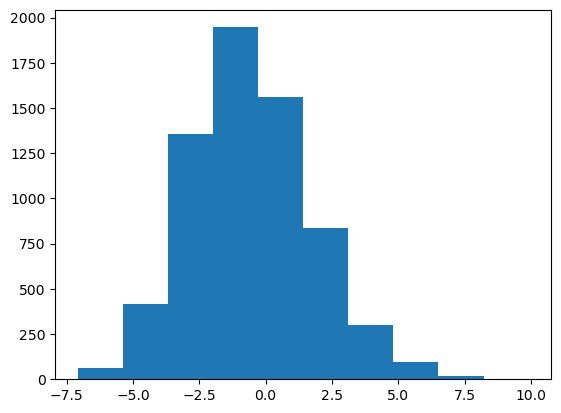

In [122]:
plt.hist(scores[0] - scores_with_features[0])

In [46]:
dataset.fit(data_interactions['userid'], 
            data_interactions['movieid'], 
            item_features=None,
            user_features=all_user_features)

In [47]:
user_features = dataset.build_user_features(data_users.user_features)

In [73]:
user_features.shape

(106402, 106415)

In [108]:
user_features.data

array([0.33333334, 0.33333334, 0.33333334, ..., 0.33333334, 0.33333334,
       0.33333334], dtype=float32)

In [107]:
user_features[:, -13:].data

array([0.33333334, 0.33333334, 0.33333334, ..., 0.33333334, 0.33333334,
       0.33333334], dtype=float32)

In [74]:
interactions.shape

(106402, 6598)

In [53]:
data_users.user_features

0         (2255153, [0, Female])
1             (37326, [0, Male])
2            (228342, [0, Male])
3          (327311, [1, Female])
4           (5015094, [1, Male])
                   ...          
108706       (797785, [1, Male])
108707    (1396285, [1, Female])
108708    (2478991, [2, Female])
108709      (3975907, [1, Male])
108710    (1289601, [2, Female])
Name: user_features, Length: 106402, dtype: object

In [48]:
interactions, weights = dataset.build_interactions(data_interactions.iloc[:, 0:3].values)

In [49]:
model = LightFM(loss='warp')

In [50]:
model.fit(interactions=interactions,
           user_features=user_features,
           item_features=None,
           epochs=5,
           sample_weight=weights);

In [76]:
user_id_map, user_feature_map, item_id_map, item_feature_map = dataset.mapping()

In [78]:
user_x = user_id_map[2255153]
n_users, n_items = interactions.shape # no of users * no of items
model.predict(user_x, np.arange(n_items)) # means predict for all

array([-0.21876435, -0.9989846 , -0.04364797, ..., -2.4278286 ,
       -2.27818   , -2.467511  ], dtype=float32)

In [51]:
data_interactions

,userid,movieid,rating,timestamp
0,2255153,21,9,2013-03-03 10:52:53
1,2255153,59,7,2013-03-10 13:54:51
2,2255153,74,7,2013-04-27 16:43:35
3,2255153,120,7,2013-03-03 10:53:57
4,2255153,178,7,2013-03-27 15:59:13
...,...,...,...,...
31284025,4862000,15611,9,2015-09-07 17:33:03
31284026,4862000,27815,9,2015-09-07 17:32:05
31284027,299167,5945,8,2010-03-29 04:24:12
31284028,263803,1316,9,2009-12-23 05:45:14


In [59]:
import scipy

In [61]:
mat = [[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]]
us_feat = scipy.sparse.csr_matrix(mat)

test_users = np.arange(1, dtype='i4')
all_items= np.arange(data_interactions.movieid.nunique(), dtype='i4')
user_index, item_index = np.meshgrid(test_users, all_items, copy=False)
lfm_scores = model.predict(
    user_ids = user_index.ravel(),
    item_ids = item_index.ravel(),
    item_features = None,
    user_features = us_feat
)
scores = lfm_scores.reshape(len(test_users), len(all_items), order='F')

In [64]:
test_users = np.arange(1, dtype='i4')
all_items= np.arange(data_interactions.movieid.nunique(), dtype='i4')
user_index, item_index = np.meshgrid(test_users, all_items, copy=False)
lfm_scores = model.predict(
    user_ids = user_index.ravel(),
    item_ids = item_index.ravel(),
    item_features = None,
    user_features = us_feat
)
scores = lfm_scores.reshape(len(test_users), len(all_items), order='F')

In [66]:
scores.shape

(1, 6598)

In [67]:
topn_recommendations(scores, topn=20)

array([[3076, 1020, 1005, 1021,  850,  975, 1002,  941, 1729, 1014, 1237,
        3054, 2808, 1760, 2993, 2847, 2891, 2674, 2857, 1724]])

In [72]:
anime_id2anime_name[850]

'Gakuen Heaven'

In [28]:
data_items

,anime_id,new_title,type,source,score,scored_by,rank,popularity,members,favorites,genre
0,11013,Inu X Boku Secret Service,TV,Manga,7.63,139250,1274.0,231,283882,2809,"Comedy, Supernatural, Romance, Shounen"
1,2104,My Bride is a Mermaid,TV,Manga,7.89,91206,727.0,366,204003,2579,"Comedy, Parody, Romance, School, Shounen"
2,5262,Shugo Chara!! Doki,TV,Manga,7.55,37129,1508.0,1173,70127,802,"Comedy, Magic, School, Shoujo"
3,721,Princess Tutu,TV,Original,8.21,36501,307.0,916,93312,3344,"Comedy, Drama, Magic, Romance, Fantasy"
4,12365,Bakuman.,TV,Manga,8.67,107767,50.0,426,182765,2082,"Comedy, Drama, Romance, Shounen"
...,...,...,...,...,...,...,...,...,...,...,...
14469,26089,Gutchonpa Omoshiro Hanashi,TV,Unknown,5.50,6,10337.0,13598,76,0,Kids
14470,21525,Geba Geba Shou Time!,OVA,Unknown,4.60,5,10236.0,13284,90,0,Comedy
14471,37897,Godzilla: Hoshi wo Kuu Mono,Movie,Other,0.00,0,NaN,7226,1741,0,"Action, Sci-Fi, Adventure, Fantasy"
14472,34193,Nippon Mukashibanashi: Sannen Netarou,OVA,Other,6.00,1,11557.0,14334,32,0,"Fantasy, Kids"


In [35]:
data_items['rank'].isnull().values.any()

True

In [44]:
data_items.genre.fillna(value='Unknonw', inplace=True)

/var/folders/bd/7mpj9jd97p5fnky8m8jmmgpw0000gn/T/ipykernel_28334/2310072926.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_items.genre.fillna(value='Unknonw', inplace=True)


In [46]:
data_items['genre_split'] = [x.split('|') for x in data_items['genre']]

/var/folders/bd/7mpj9jd97p5fnky8m8jmmgpw0000gn/T/ipykernel_28334/1002132889.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_items['genre_split'] = [x.split('|') for x in data_items['genre']]


In [47]:
data_items

,anime_id,new_title,type,source,score,scored_by,rank,popularity,members,favorites,genre,genre_split
0,11013,Inu X Boku Secret Service,TV,Manga,7.63,139250,1274.0,231,283882,2809,"Comedy, Supernatural, Romance, Shounen","[Comedy, Supernatural, Romance, Shounen]"
1,2104,My Bride is a Mermaid,TV,Manga,7.89,91206,727.0,366,204003,2579,"Comedy, Parody, Romance, School, Shounen","[Comedy, Parody, Romance, School, Shounen]"
2,5262,Shugo Chara!! Doki,TV,Manga,7.55,37129,1508.0,1173,70127,802,"Comedy, Magic, School, Shoujo","[Comedy, Magic, School, Shoujo]"
3,721,Princess Tutu,TV,Original,8.21,36501,307.0,916,93312,3344,"Comedy, Drama, Magic, Romance, Fantasy","[Comedy, Drama, Magic, Romance, Fantasy]"
4,12365,Bakuman.,TV,Manga,8.67,107767,50.0,426,182765,2082,"Comedy, Drama, Romance, Shounen","[Comedy, Drama, Romance, Shounen]"
...,...,...,...,...,...,...,...,...,...,...,...,...
14469,26089,Gutchonpa Omoshiro Hanashi,TV,Unknown,5.50,6,10337.0,13598,76,0,Kids,[Kids]
14470,21525,Geba Geba Shou Time!,OVA,Unknown,4.60,5,10236.0,13284,90,0,Comedy,[Comedy]
14471,37897,Godzilla: Hoshi wo Kuu Mono,Movie,Other,0.00,0,NaN,7226,1741,0,"Action, Sci-Fi, Adventure, Fantasy","[Action, Sci-Fi, Adventure, Fantasy]"
14472,34193,Nippon Mukashibanashi: Sannen Netarou,OVA,Other,6.00,1,11557.0,14334,32,0,"Fantasy, Kids","[Fantasy, Kids]"


In [48]:
clean_data_items = data_items# clean_data_items = data_items.dropna()

In [49]:
data_items.anime_id.nunique()

14474

In [50]:
anime_genre = [x.split(', ') for x in clean_data_items['genre']]

In [51]:
scores_items_features = list(set(clean_data_items['score']))

In [52]:
for i in range(len(scores_items_features)):
    scores_items_features[i] = int(scores_items_features[i])

In [53]:
clean_data_items.members.max()

1456378

In [54]:
list(set(scores_items_features))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [55]:
import itertools

In [56]:
source_feature = sorted(list(set(clean_data_items['source'])))
genre_feature = sorted(list(set(itertools.chain.from_iterable(anime_genre))))
type_feature = sorted(list(set(clean_data_items['type'])))
score_feature = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
members_feature = [100000 * i for i in range(15)]

In [57]:
clean_data_items['intscore'] = clean_data_items.score.apply(lambda x: str(int(x)))

/var/folders/bd/7mpj9jd97p5fnky8m8jmmgpw0000gn/T/ipykernel_28334/4112513335.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_items['intscore'] = clean_data_items.score.apply(lambda x: int(x))


In [58]:
clean_data_items['new_member_feat'] = clean_data_items.members.apply(lambda x: str(x // 100000))

/var/folders/bd/7mpj9jd97p5fnky8m8jmmgpw0000gn/T/ipykernel_28334/3662694188.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_items['new_member_feat'] = clean_data_items.members.apply(lambda x: x // 100000)


In [59]:
clean_data_items

,anime_id,new_title,type,source,score,scored_by,rank,popularity,members,favorites,genre,genre_split,intscore,new_member_feat
0,11013,Inu X Boku Secret Service,TV,Manga,7.63,139250,1274.0,231,283882,2809,"Comedy, Supernatural, Romance, Shounen","[Comedy, Supernatural, Romance, Shounen]",7,2
1,2104,My Bride is a Mermaid,TV,Manga,7.89,91206,727.0,366,204003,2579,"Comedy, Parody, Romance, School, Shounen","[Comedy, Parody, Romance, School, Shounen]",7,2
2,5262,Shugo Chara!! Doki,TV,Manga,7.55,37129,1508.0,1173,70127,802,"Comedy, Magic, School, Shoujo","[Comedy, Magic, School, Shoujo]",7,0
3,721,Princess Tutu,TV,Original,8.21,36501,307.0,916,93312,3344,"Comedy, Drama, Magic, Romance, Fantasy","[Comedy, Drama, Magic, Romance, Fantasy]",8,0
4,12365,Bakuman.,TV,Manga,8.67,107767,50.0,426,182765,2082,"Comedy, Drama, Romance, Shounen","[Comedy, Drama, Romance, Shounen]",8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14469,26089,Gutchonpa Omoshiro Hanashi,TV,Unknown,5.50,6,10337.0,13598,76,0,Kids,[Kids],5,0
14470,21525,Geba Geba Shou Time!,OVA,Unknown,4.60,5,10236.0,13284,90,0,Comedy,[Comedy],4,0
14471,37897,Godzilla: Hoshi wo Kuu Mono,Movie,Other,0.00,0,NaN,7226,1741,0,"Action, Sci-Fi, Adventure, Fantasy","[Action, Sci-Fi, Adventure, Fantasy]",0,0
14472,34193,Nippon Mukashibanashi: Sannen Netarou,OVA,Other,6.00,1,11557.0,14334,32,0,"Fantasy, Kids","[Fantasy, Kids]",6,0


In [62]:
clean_data_items.columns

Index(['anime_id', 'new_title', 'type', 'source', 'score', 'scored_by', 'rank',
       'popularity', 'members', 'favorites', 'genre', 'genre_split',
       'intscore', 'new_member_feat'],
      dtype='object')

In [64]:
pd.get_dummies(clean_data_items[['type', 'source', 'intscore', 'new_member_feat']])

,intscore,new_member_feat,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV,type_Unknown,source_4-koma manga,...,source_Manga,source_Music,source_Novel,source_Original,source_Other,source_Picture book,source_Radio,source_Unknown,source_Visual novel,source_Web manga
0,7,2,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1,7,2,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
2,7,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
3,8,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,8,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14469,5,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
14470,4,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
14471,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
14472,6,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [60]:
item_features = genre_feature + source_feature + type_feature + score_feature + members_feature

In [61]:
dataset.fit(users=data_interactions['userid'], 
            items=data_interactions['movieid'], 
            item_features=item_features,
            user_features=None)

# quick check to determine the number of unique users and items in the data
num_users, num_topics = dataset.interactions_shape()
print(f'Num users: {num_users}, num_topics: {num_topics}.')

Num users: 116133, num_topics: 14474.


In [43]:
clean_data_items['genre_feature'] = list(map(tuple, zip(clean_data_items['anime_id'], clean_data_items['genre_split'])))

/var/folders/bd/7mpj9jd97p5fnky8m8jmmgpw0000gn/T/ipykernel_23966/4012573671.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_items['genre_feature'] = list(map(tuple, zip(clean_data_items['anime_id'], clean_data_items['genre_list'])))


In [44]:
clean_data_items

,anime_id,new_title,type,source,score,scored_by,rank,popularity,members,favorites,genre,intscore,new_member_feat,genre_list,genre_feature
0,11013,Inu X Boku Secret Service,TV,Manga,7.63,139250,1274.0,231,283882,2809,"Comedy, Supernatural, Romance, Shounen",7,2,"[Comedy, Supernatural, Romance, Shounen]","(11013, [Comedy, Supernatural, Romance, Shounen])"
1,2104,My Bride is a Mermaid,TV,Manga,7.89,91206,727.0,366,204003,2579,"Comedy, Parody, Romance, School, Shounen",7,2,"[Comedy, Parody, Romance, School, Shounen]","(2104, [Comedy, Parody, Romance, School, Shoun..."
2,5262,Shugo Chara!! Doki,TV,Manga,7.55,37129,1508.0,1173,70127,802,"Comedy, Magic, School, Shoujo",7,0,"[Comedy, Magic, School, Shoujo]","(5262, [Comedy, Magic, School, Shoujo])"
3,721,Princess Tutu,TV,Original,8.21,36501,307.0,916,93312,3344,"Comedy, Drama, Magic, Romance, Fantasy",8,0,"[Comedy, Drama, Magic, Romance, Fantasy]","(721, [Comedy, Drama, Magic, Romance, Fantasy])"
4,12365,Bakuman.,TV,Manga,8.67,107767,50.0,426,182765,2082,"Comedy, Drama, Romance, Shounen",8,1,"[Comedy, Drama, Romance, Shounen]","(12365, [Comedy, Drama, Romance, Shounen])"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14468,35040,Minna no Taabou Konnichiwa,OVA,Original,6.75,4,11329.0,14204,40,0,Kids,6,0,[Kids],"(35040, [Kids])"
14469,26089,Gutchonpa Omoshiro Hanashi,TV,Unknown,5.50,6,10337.0,13598,76,0,Kids,5,0,[Kids],"(26089, [Kids])"
14470,21525,Geba Geba Shou Time!,OVA,Unknown,4.60,5,10236.0,13284,90,0,Comedy,4,0,[Comedy],"(21525, [Comedy])"
14472,34193,Nippon Mukashibanashi: Sannen Netarou,OVA,Other,6.00,1,11557.0,14334,32,0,"Fantasy, Kids",6,0,"[Fantasy, Kids]","(34193, [Fantasy, Kids])"


In [45]:
anime_features = dataset.build_item_features(
    clean_data_items['genre_feature'])

In [46]:
(interactions, weights) = dataset.build_interactions(data_interactions.iloc[:, 0:3].values)

In [47]:
interactions.data

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [32]:
# default number of recommendations
K = 10
# percentage of data used for testing
TEST_PERCENTAGE = 0.25
# model learning rate
LEARNING_RATE = 0.25
# no of latent factors
NO_COMPONENTS = 20
# no of epochs to fit model
NO_EPOCHS = 20
# no of threads to fit model
NO_THREADS = 32
# regularisation for both user and item features
ITEM_ALPHA=1e-6
USER_ALPHA=1e-6

# seed for pseudonumber generations
SEEDNO = 42

In [48]:
model = LightFM(
    no_components=150,
    learning_rate=0.05,
    loss='warp',
    random_state=2023)

model.fit(
    interactions=interactions,
    item_features=anime_features,
    user_features=None, sample_weight=weights,
    epochs=5, num_threads=4, verbose=True)

Epoch: 100%|██████████| 5/5 [16:21<00:00, 196.35s/it]


In [98]:
item_feature_bias, item_feature_factors = model.get_item_representations()

In [100]:
item_feature_bias.shape

(6598,)

In [101]:
item_feature_factors.shape

(6598, 10)

In [102]:
item_feature_factors

array([[ 0.2767108 , -0.19116786,  1.6545511 , ..., -0.5015664 ,
         0.2814411 , -0.6985297 ],
       [-0.04602526,  0.6487138 ,  0.46516854, ..., -0.95408034,
         0.47696602, -1.0574816 ],
       [-0.74456376,  0.80818343,  0.9863542 , ..., -0.35896376,
         0.16943401, -0.58359367],
       ...,
       [-0.4463524 ,  0.450185  ,  0.13979891, ...,  0.81040955,
        -0.36499563,  0.52924204],
       [-0.3819836 ,  0.28298807,  0.24830365, ...,  0.6583635 ,
        -0.33693382,  0.62621576],
       [-0.40665823,  0.36508727,  0.00845438, ...,  0.7062319 ,
        -0.44427258,  0.5536702 ]], dtype=float32)

In [105]:
model.get_params

<bound method LightFM.get_params of <lightfm.lightfm.LightFM object at 0x7fe922f340a0>>

In [104]:
item_feature_map

{21: 0,
 59: 1,
 74: 2,
 120: 3,
 178: 4,
 210: 5,
 232: 6,
 233: 7,
 249: 8,
 269: 9,
 721: 10,
 853: 11,
 857: 12,
 957: 13,
 966: 14,
 1557: 15,
 1571: 16,
 1579: 17,
 1698: 18,
 1735: 19,
 1914: 20,
 1974: 21,
 2104: 22,
 2564: 23,
 2787: 24,
 3092: 25,
 3731: 26,
 4224: 27,
 4477: 28,
 4722: 29,
 4814: 30,
 5262: 31,
 5690: 32,
 5835: 33,
 6045: 34,
 6586: 35,
 6645: 36,
 7054: 37,
 7674: 38,
 7817: 39,
 9513: 40,
 9656: 41,
 9863: 42,
 9926: 43,
 10030: 44,
 10800: 45,
 11013: 46,
 11123: 47,
 11759: 48,
 12365: 49,
 14227: 50,
 14397: 51,
 14713: 52,
 1: 53,
 7: 54,
 19: 55,
 20: 56,
 24: 57,
 30: 58,
 32: 59,
 45: 60,
 57: 61,
 60: 62,
 68: 63,
 121: 64,
 145: 65,
 150: 66,
 164: 67,
 199: 68,
 202: 69,
 205: 70,
 227: 71,
 228: 72,
 235: 73,
 237: 74,
 245: 75,
 270: 76,
 323: 77,
 339: 78,
 387: 79,
 405: 80,
 419: 81,
 431: 82,
 457: 83,
 732: 84,
 934: 85,
 1482: 86,
 1535: 87,
 1575: 88,
 1604: 89,
 1689: 90,
 1829: 91,
 2001: 92,
 2025: 93,
 2167: 94,
 2236: 95,
 2251: 96

In [ ]:
def warm_start(model, user_preferences, item_):
    item_feature_bias, item_feature_factors = model.get_item_representations()
    item_factors = (item_features @ item_feature_factors)
    item_bias = (item_features @ item_feature_bias)
    item_factors_inv = np.linalg.pinv(item_factors)
    
    new_user_to_item = sparse row binary matrix (all ratings of 1)
    
    user_factors = (item_factors_inv @ new_user_to_item.T).T
    predictions = user_factors @ item_factors.T + item_bias
    return predictions

In [ ]:
count = 0
for x in data_interactions[['userid', 'movieid']].values:
    print(x[1])
    count += 1
    if count == 5:
        break

21
21
21
21
21


In [ ]:
data_interactions

In [ ]:
dataset.fit((x for x in data_interactions['userid']),
            (x for x in data_interactions['movieid']))

In [ ]:
num_users, num_items = dataset.interactions_shape()
print('Num users: {}, num_items {}.'.format(num_users, num_items))

Num users: 113236, num_items 13647.


In [ ]:
(interactions, weights) = dataset.build_interactions(((x[0], x[1]) for x in data_interactions[['userid', 'movieid']].values))

print(repr(interactions))

<113236x13647 sparse matrix of type '<class 'numpy.int32'>'
	with 21633593 stored elements in COOrdinate format>


In [ ]:
interactions.data

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [ ]:
dataset.build_interactions()